In [61]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import tqdm
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [3]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
eval_dir = '/opt/ml/input/data/eval'
train_dir = '/opt/ml/input/data/train'

# 1.EDA

In [4]:
train_data = pd.read_csv(os.path.join(train_dir, 'train.csv'))

In [5]:
train_data.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


Text(0.5, 1.0, 'Race')

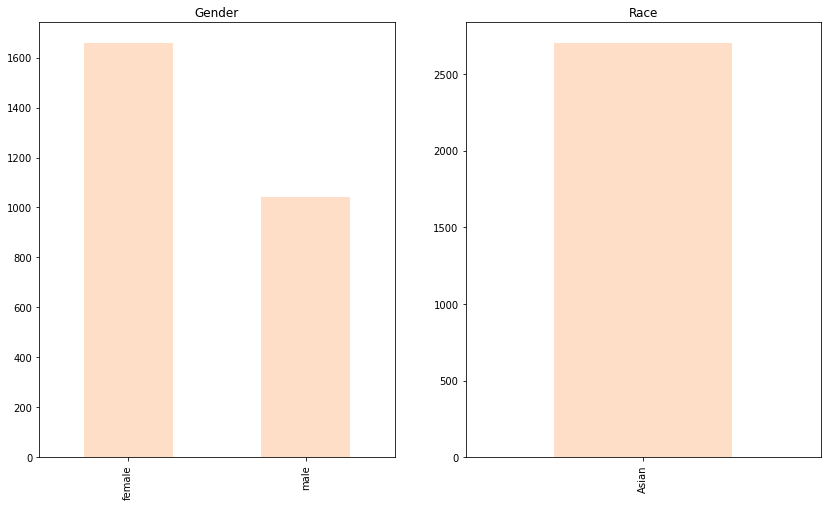

In [6]:
y_position = 1.02
f, ax = plt.subplots(1,2,figsize = (14,8))
train_data['gender'].value_counts().plot.bar(color = "#FFD8BFD8",ax = ax[0]).set_title("Gender")
train_data['race'].value_counts().plot.bar(color = "#FFD8BFD8",ax = ax[1]).set_title("Race")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


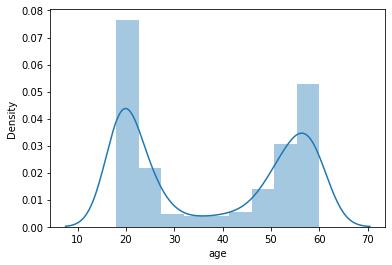

In [7]:
sns.distplot(train_data['age'])
plt.show()

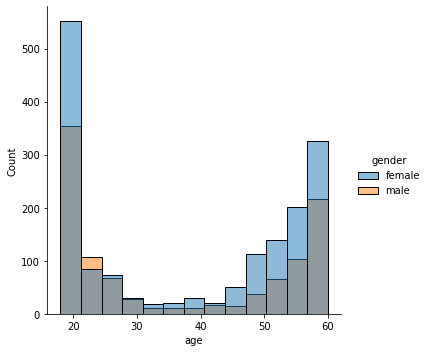

In [8]:
sns.displot(train_data, x="age", hue = "gender")

In [9]:
import cv2
classname = ["incorrect_mask", "mask1", "mask2", "mask3", "mask4", "mask5", "normal"]
for i in range(0,0):
    count = 0
    for c in classname:
        img = cv2.imread((train_filename[i] + '/' + c + '.jpg'), cv2.IMREAD_COLOR)
        #cv2.imshow('image',img)
        plt.imshow(img)
        plt.show()
        #print(img)

In [10]:
# train_image_before_Deduplication = os.listdir(f"{train_dir}/images")
# train_image_after_Deduplication = [f for f in os.listdir(f"{train_dir}/images") if not f.startswith('.')]  
# print("train_image_before_Deduplication",len(train_image_before_Deduplication))
# print("train_image_after_Deduplication",len(train_image_after_Deduplication))


In [11]:
# train_filename = []
# for i in train_image_after_Deduplication:
#     train_filename.append(os.path.join(f'{train_dir}/images', i))

In [12]:
# 3월 31일 수정 후.
train_filename = glob.glob(f'{train_dir}/images/*')

# 2.Data Feeding

# 3.Dataset

In [17]:
class MyDataset(Dataset):
    def __init__(self, train_filename):
        self.train_filename = train_filename
    
    def __len__(self):
        return len(train_filename)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        tf = glob.glob(f"{train_filename[idx]}/*")
        res = []
        for i in tf:
            label = 0
            tmp = i.split('/')
            if 'incorrect_mask' in tmp[-1]:
                label += 6
            elif 'normal' in tmp[-1]:
                label += 12
            tmp = tmp[-2].split('_')
            if tmp[1] == 'female':
                label += 3
            if int(tmp[3]) >= 30 and int(tmp[3]) < 60:
                label += 1
            elif int(tmp[3]) >= 60:
                label += 2
            img = Image.open(i)
            res.append((img, label))
        return res
 

In [65]:
# dataset
dataset = MyDataset(train_filename)
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

# dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=100,
    num_workers=4,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=100,
    num_workers=4,
    shuffle=False
)


In [67]:
for a,b in val_loader:
    print(a)
    print(b)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 86, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>


# 4.Model

In [39]:
model = models.resnet152(pretrained=True)

In [40]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

In [41]:
model.fc = nn.Sequential(
    nn.Linear(2048, 18, bias = True)
)

In [52]:
# weight freeze
# 하는것과 안하는것의 차이?
for param in model.parameters():
    param.requires_grad = False

In [53]:
# Weight initialization
# 하는거 안하는거 차이?
import torch.nn.init as init

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

In [54]:
initialize_weights(model.fc)

# 5.train

In [55]:
batch_size = 256
num_epochs = 15

In [63]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                model.train()  # Set model to training mode
            else:
                dataloader = val_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # is_inception은 무슨 경우?
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [64]:
# model, train_loader, val_loader, criterion, optimizer, num_epochs=25, is_inception=False
criterion = nn.CrossEntropyLoss()
optm = torch.optim.Adam(model.parameters(), lr = 1e-3)
train_model(model = model, train_loater = train_loader, val_loader = val_loader, criterion, optm, num_epochs=15)


Epoch 0/14
----------


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 86, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>
